In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 102.1 MB/s eta 0:00:00


In [3]:
# Imports and Setup
import numpy as np
import rasterio
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 1. Load all rasters as 2D arrays (change base_path as needed)
base_path = "/content/drive/MyDrive/EarthEngine/"

def load_raster(filename):
    with rasterio.open(os.path.join(base_path, filename)) as src:
        return src.read(1), src

dem, dem_src = load_raster("dem_small.tif")
slope, _ = load_raster("slope.tif")
aspect, _ = load_raster("aspect.tif")
lulc, _ = load_raster("lulc_small_resampled.tif")
temp, _ = load_raster("temperature_resampled.tif")
rain, _ = load_raster("rainfall_resampled.tif")
wind_u, _ = load_raster("wind_u_resampled.tif")
wind_v, _ = load_raster("wind_v_resampled.tif")
humidity, _ = load_raster("humidity_resampled.tif")
ghsl, _ = load_raster("ghsl_built_pct_resampled.tif")
fire, _ = load_raster("fire_points_binary.tif")
fire_binary = (fire > 0).astype(np.uint8)

In [5]:
# 2. Ensure all rasters are the same shape
shape = dem.shape
assert all(arr.shape == shape for arr in [
    slope, aspect, lulc, temp, rain, wind_u, wind_v, humidity, ghsl, fire_binary
]), "All input rasters must have the same shape!"


In [6]:
# 3. Mask out nodata (2D mask)
nodata = -9999  # Set to your actual nodata value
valid_mask = (
    (dem != nodata) &
    (slope != nodata) &
    (aspect != nodata) &
    (lulc != nodata) &
    (temp != nodata) &
    (rain != nodata) &
    (wind_u != nodata) &
    (wind_v != nodata) &
    (humidity != nodata) &
    (ghsl != nodata)
)  # shape: (height, width)


In [7]:

# 4. Prepare features for ML (mask then flatten only valid pixels)
def flatten_valid(arr):
    return arr[valid_mask]

dem_masked = flatten_valid(dem)
slope_masked = flatten_valid(slope)
aspect_masked = flatten_valid(aspect)
lulc_masked = flatten_valid(lulc)
temp_masked = flatten_valid(temp)
rain_masked = flatten_valid(rain)
wind_u_masked = flatten_valid(wind_u)
wind_v_masked = flatten_valid(wind_v)
humidity_masked = flatten_valid(humidity)
ghsl_masked = flatten_valid(ghsl)
fire_binary_masked = flatten_valid(fire_binary)

In [8]:
# 5. Scaling and encoding
scaler = MinMaxScaler()
cont_features = np.stack(
    [dem_masked, slope_masked, aspect_masked, temp_masked, rain_masked,
     wind_u_masked, wind_v_masked, humidity_masked, ghsl_masked], axis=1
)
cont_features_scaled = scaler.fit_transform(cont_features)

lulc_reshaped = lulc_masked.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
lulc_onehot = encoder.fit_transform(lulc_reshaped)


In [9]:
# 6. Stack features
X = np.concatenate([cont_features_scaled, lulc_onehot], axis=1)
y = fire_binary_masked

In [10]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
# 8. Model training
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [12]:
# 9. Threshold tuning
y_probs = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
thresholds = np.append(thresholds, 1.0)

chosen_threshold = 0.3
y_pred_balanced = (y_probs >= chosen_threshold).astype(int)

print("Confusion matrix at chosen threshold:")
print(confusion_matrix(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced, target_names=['No Fire', 'Fire']))

Confusion matrix at chosen threshold:
[[226056   5276]
 [  1551  13698]]
              precision    recall  f1-score   support

     No Fire       0.99      0.98      0.99    231332
        Fire       0.72      0.90      0.80     15249

    accuracy                           0.97    246581
   macro avg       0.86      0.94      0.89    246581
weighted avg       0.98      0.97      0.97    246581



In [13]:
# 10. --- Full map prediction for all valid pixels ---
# Prepare features for all valid pixels as above
all_features = np.stack([
    dem_masked, slope_masked, aspect_masked, temp_masked, rain_masked,
    wind_u_masked, wind_v_masked, humidity_masked, ghsl_masked
], axis=1)
all_features_scaled = scaler.transform(all_features)
lulc_masked_reshaped = lulc_masked.reshape(-1, 1)
lulc_masked_onehot = encoder.transform(lulc_masked_reshaped)
all_X_full = np.concatenate([all_features_scaled, lulc_masked_onehot], axis=1)

all_pred_probs = clf.predict_proba(all_X_full)[:, 1]
all_pred = (all_pred_probs >= chosen_threshold).astype(int)


In [14]:
# 11. Fill full 2D map arrays
full_pred_map = np.full(shape, np.nan)
full_actual_map = np.full(shape, np.nan)
full_pred_map[valid_mask] = all_pred
full_actual_map[valid_mask] = fire_binary_masked

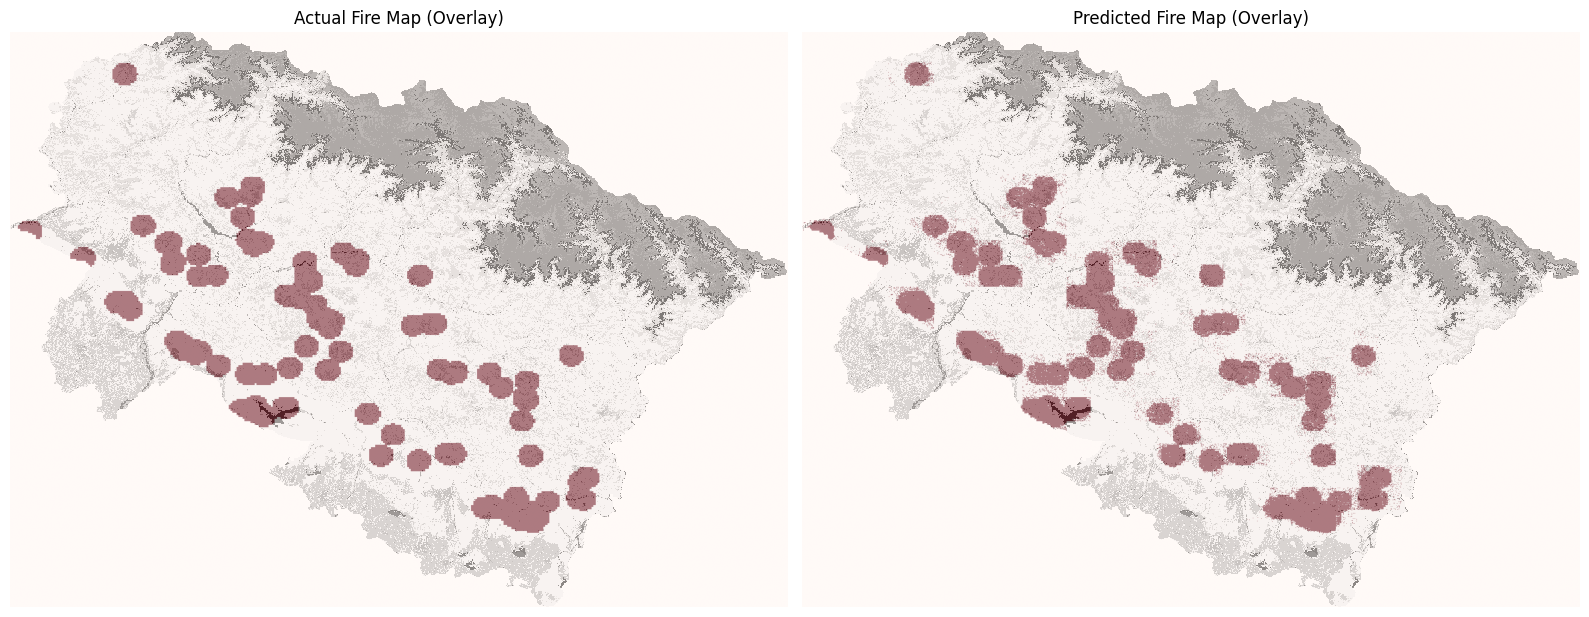

In [15]:
import matplotlib.pyplot as plt

# use DEM as background (or use any base raster you prefer)
background = lulc  # Or another raster, like temp, lulc, etc.

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# 1. Actual fire map overlay
axs[0].imshow(background, cmap='Greys', interpolation='none')
axs[0].imshow(full_actual_map, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
axs[0].set_title('Actual Fire Map (Overlay)')
axs[0].axis('off')

# 2. Predicted fire map overlay
axs[1].imshow(background, cmap='Greys', interpolation='none')
axs[1].imshow(full_pred_map, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
axs[1].set_title('Predicted Fire Map (Overlay)')
axs[1].axis('off')

plt.tight_layout()
plt.show()


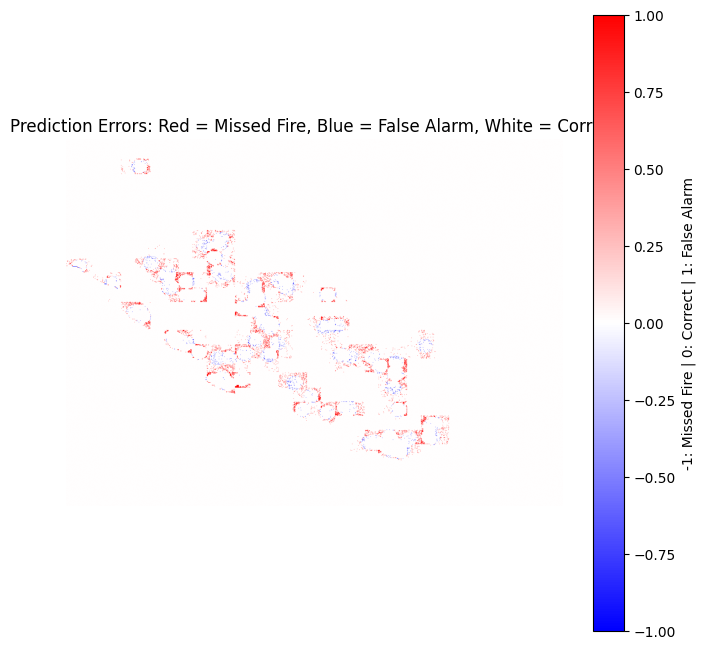

In [16]:
# 13. Optional: Show difference/error map

diff_map = np.full(shape, np.nan)
diff_map[valid_mask] = full_pred_map[valid_mask] - full_actual_map[valid_mask]
plt.figure(figsize=(8, 8))
plt.imshow(diff_map, cmap='bwr', vmin=-1, vmax=1)
plt.title('Prediction Errors: Red = Missed Fire, Blue = False Alarm, White = Correct')
plt.colorbar(label='-1: Missed Fire | 0: Correct | 1: False Alarm')
plt.axis('off')
plt.show()

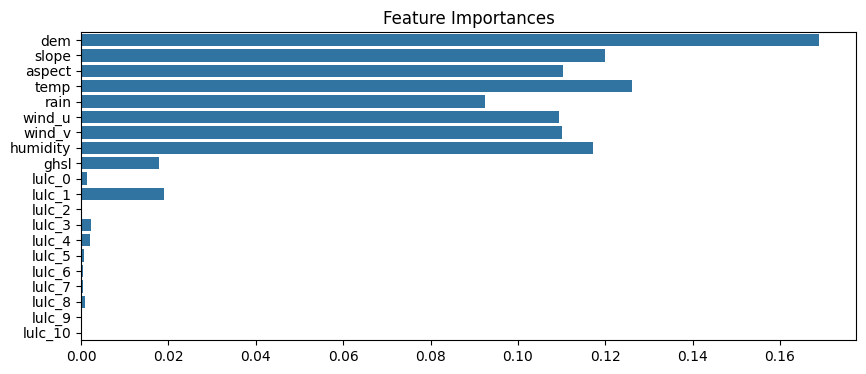

In [17]:
importances = clf.feature_importances_
feature_names = ['dem', 'slope', 'aspect', 'temp', 'rain', 'wind_u', 'wind_v', 'humidity', 'ghsl'] + \
                [f'lulc_{i}' for i in range(lulc_onehot.shape[1])]
plt.figure(figsize=(10,4))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")
plt.show()

File: /content/drive/MyDrive/EarthEngine/ForestFireRisk_resampled.tif
CRS: EPSG:4326
Shape (height, width): (955, 1291)
Number of bands: 1
Dtype: ('int8',)


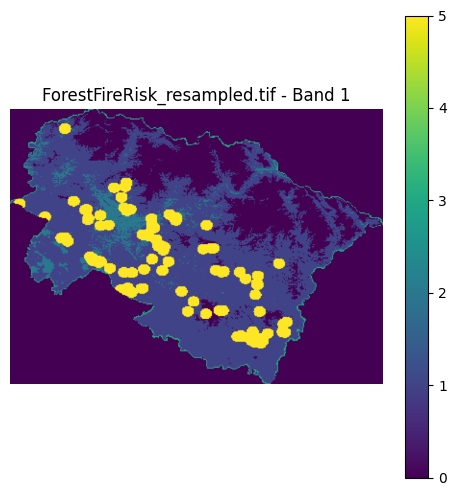

File: /content/drive/MyDrive/EarthEngine/fire_points_binary.tif
CRS: EPSG:4326
Shape (height, width): (955, 1291)
Number of bands: 1
Dtype: ('uint8',)


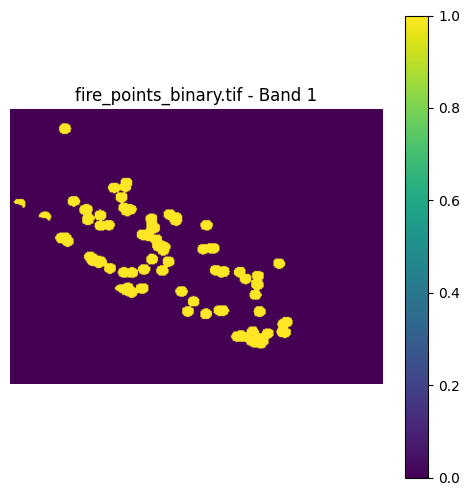

File: /content/drive/MyDrive/EarthEngine/stacked_input.tif
CRS: EPSG:4326
Shape (height, width): (955, 1291)
Number of bands: 10
Dtype: ('float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32')


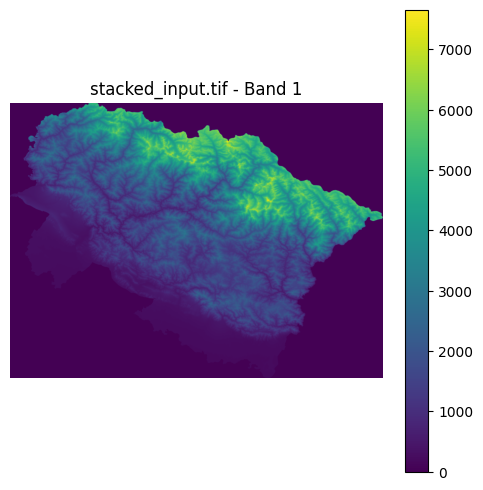

In [18]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# List of files to view
files = [
    "/content/drive/MyDrive/EarthEngine/ForestFireRisk_resampled.tif",
    "/content/drive/MyDrive/EarthEngine/fire_points_binary.tif",
    "/content/drive/MyDrive/EarthEngine/stacked_input.tif"
]

for file in files:
    print("="*50)
    print(f"File: {file}")
    with rasterio.open(file) as src:
        print("CRS:", src.crs)
        print("Shape (height, width):", src.shape)
        print("Number of bands:", src.count)
        print("Dtype:", src.dtypes)
        # Read first band for display
        arr = src.read(1)
        # Display
        plt.figure(figsize=(6, 6))
        plt.imshow(arr, cmap='viridis')
        plt.colorbar()
        plt.title(f"{file.split('/')[-1]} - Band 1")
        plt.axis('off')
        plt.show()

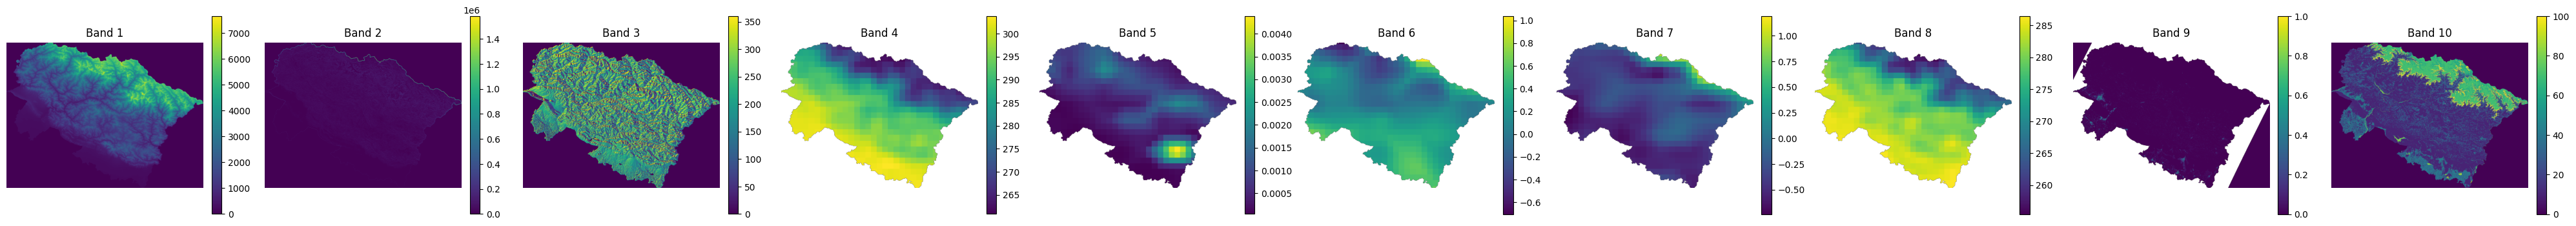

In [19]:
import rasterio
import matplotlib.pyplot as plt

# Path to your multi-band raster
raster_path = "/content/drive/MyDrive/EarthEngine/stacked_input.tif"

with rasterio.open(raster_path) as src:
    n_bands = src.count
    fig, axes = plt.subplots(1, n_bands, figsize=(4*n_bands, 4))
    if n_bands == 1:
        axes = [axes]  # Make iterable if only one band
    for i in range(n_bands):
        band = src.read(i + 1)
        ax = axes[i]
        im = ax.imshow(band, cmap='viridis')
        ax.set_title(f"Band {i+1}")
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

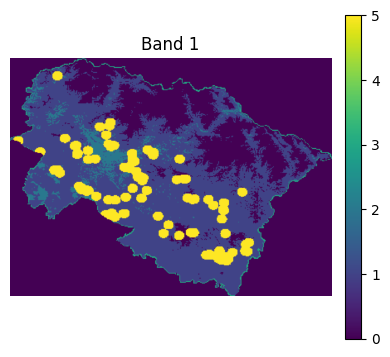

In [20]:
import rasterio
import matplotlib.pyplot as plt

# Path to your multi-band raster
raster_path = "/content/drive/MyDrive/EarthEngine/ForestFireRisk_resampled.tif"

with rasterio.open(raster_path) as src:
    n_bands = src.count
    fig, axes = plt.subplots(1, n_bands, figsize=(4*n_bands, 4))
    if n_bands == 1:
        axes = [axes]  # Make iterable if only one band
    for i in range(n_bands):
        band = src.read(i + 1)
        ax = axes[i]
        im = ax.imshow(band, cmap='viridis')
        ax.set_title(f"Band {i+1}")
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

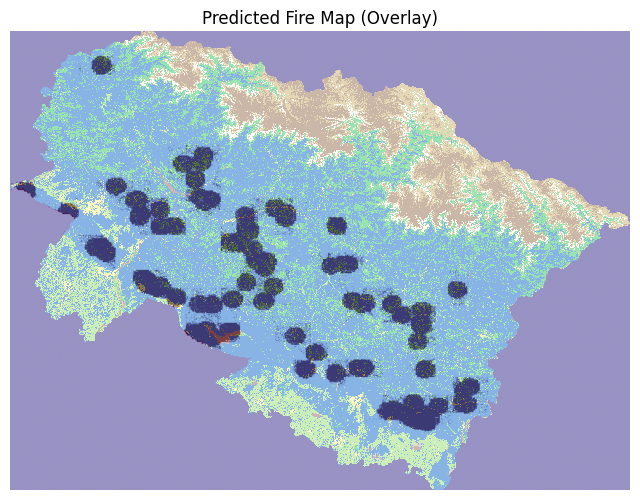

✅ Saved overlay image to: /content/drive/MyDrive/EarthEngine/predicted_fire_overlay.png


In [21]:
import matplotlib.pyplot as plt

# Use LULC or any raster as background
background = lulc  # should be 2D array
overlay = full_pred_map  # should also be 2D array with 0/1 values

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot base and overlay
ax.imshow(background, cmap='terrain', interpolation='none')
ax.imshow(overlay, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
ax.set_title('Predicted Fire Map (Overlay)')
ax.axis('off')

# Save the figure
output_path = '/content/drive/MyDrive/EarthEngine/predicted_fire_overlay.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved overlay image to: {output_path}")


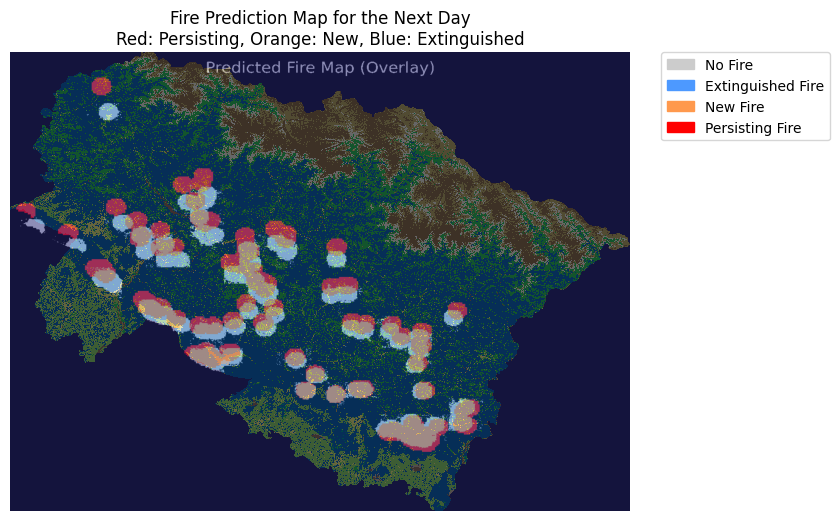

In [22]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as mpatches

# Load today fire map (reference, binary mask, 0/1)
with rasterio.open('/content/drive/MyDrive/EarthEngine/fire_points_binary.tif') as src:
    today_map = src.read(1)
    ref_shape = today_map.shape

# Load tomorrow's predicted fire map (PNG, needs resize)
pred_path = '/content/drive/MyDrive/EarthEngine/predicted_fire_overlay.png'
if pred_path.endswith('.tif'):
    with rasterio.open(pred_path) as src:
        tomorrow_pred = src.read(1)
elif pred_path.endswith('.png'):
    pil_pred = Image.open(pred_path).convert('L')
    pil_pred = pil_pred.resize((ref_shape[1], ref_shape[0]), Image.BILINEAR)
    tomorrow_pred = np.array(pil_pred) / 255.0

# Threshold prediction if not already binary
tomorrow_pred_bin = (tomorrow_pred > 0.5).astype(int)

# Load background and resize if needed
with rasterio.open('/content/drive/MyDrive/EarthEngine/lulc_small_resampled.tif') as src:
    background = src.read(1)
if background.shape != ref_shape:
    # Resize background (if needed)
    background = np.array(Image.fromarray(background).resize((ref_shape[1], ref_shape[0]), Image.NEAREST))

# Create fire growth composite
combo = today_map*2 + tomorrow_pred_bin

colors = np.array([
    [0.8,0.8,0.8], # 0: background (no fire)
    [0.0,0.0,0.0], # 1: extinguished (blue)
    [1.0,0.6,0.3], # 2: new fire (orange)
    [1.0,0.0,0.0], # 3: persisting fire (red)
])
rgb_combo = colors[combo]

labels = [
    "No Fire",
    "Extinguished Fire",
    "New Fire",
    "Persisting Fire"
]

fig, ax = plt.subplots(figsize=(8,8))
patches = [
    mpatches.Patch(
        color=(0.3, 0.6, 1.0) if lab == "Extinguished Fire" else col,  # blue for extinguished
        label=lab
    )
    for col, lab in zip(colors, labels)
]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.imshow(background, cmap='terrain', interpolation='none')
ax.imshow(rgb_combo, alpha=0.6)
ax.set_title('Fire Prediction Map for the Next Day\nRed: Persisting, Orange: New, Blue: Extinguished')
ax.axis('off')
plt.show()

In [23]:
print("today_map unique values:", np.unique(today_map))
print("tomorrow_pred_bin unique values:", np.unique(tomorrow_pred_bin))

today_map unique values: [0 1]
tomorrow_pred_bin unique values: [0 1]


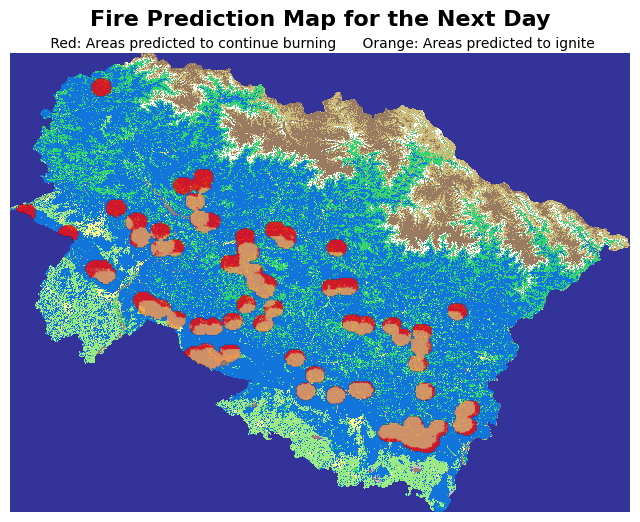

In [24]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as mpatches

# Load today fire map (reference, binary mask, 0/1)
with rasterio.open('/content/drive/MyDrive/EarthEngine/fire_points_binary.tif') as src:
    today_map = src.read(1)
    ref_shape = today_map.shape

# Load tomorrow's predicted fire map (PNG, needs resize)
pred_path = '/content/drive/MyDrive/EarthEngine/predicted_fire_overlay.png'
if pred_path.endswith('.tif'):
    with rasterio.open(pred_path) as src:
        tomorrow_pred = src.read(1)
elif pred_path.endswith('.png'):
    pil_pred = Image.open(pred_path).convert('L')
    pil_pred = pil_pred.resize((ref_shape[1], ref_shape[0]), Image.BILINEAR)
    tomorrow_pred = np.array(pil_pred) / 255.0

# Threshold prediction if not already binary
tomorrow_pred_bin = (tomorrow_pred > 0.5).astype(int)

# Load background and resize if needed
with rasterio.open('/content/drive/MyDrive/EarthEngine/lulc_small_resampled.tif') as src:
    background = src.read(1)
if background.shape != ref_shape:
    background = np.array(Image.fromarray(background).resize((ref_shape[1], ref_shape[0]), Image.NEAREST))

# Create fire growth composite
combo = today_map*2 + tomorrow_pred_bin

# Only keep "new fire" and "persisting fire" for overlay (set other to transparent)
overlay = np.zeros((*combo.shape, 4))  # RGBA
overlay[combo == 2] = [1.0, 0.6, 0.3, 0.8]  # New fire (orange, semi-transparent)
overlay[combo == 3] = [1.0, 0.0, 0.0, 0.8]  # Persisting fire (red, semi-transparent)

# Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(background, cmap='terrain', interpolation='none')
ax.imshow(overlay)
#ax.set_title('Fire Prediction Map for the Next Day \n Red: Areas predicted to continue burning \nOrange: Areas predicted to ignite')
ax.axis('off')

# Custom legend
# patches = [
#     mpatches.Patch(color=(1.0, 0.0, 0.0, 0.8), label='Areas predicted to continue burning'),
#     mpatches.Patch(color=(1.0, 0.6, 0.3, 0.8), label='Areas predicted to ignite')
# ]
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# Main bold title
ax.set_title('Fire Prediction Map for the Next Day', fontsize=16, fontweight='bold', pad=20)

# Subtitle lines (smaller, normal weight)
plt.text(
    0.5, 1.04,
    '\n Red: Areas predicted to continue burning      Orange: Areas predicted to ignite',
    fontsize=10,
    ha='center',
    va='center',
    transform=ax.transAxes
)
# plt.text(
#     0.5, 1.08,
#     'Orange: Areas predicted to ignite',
#     fontsize=10,
#     ha='center',
#     va='center',
#     transform=ax.transAxes
# )
plt.show()